Heat load calculation (Wendelstein 7-X)
================================

This example shows how to create headßload distribution plots for Wendelstein 7-X. First, we need to perform some setup to make sure W7-X data are available.

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration.

In [3]:
field = w7x.standard()
geometry = w7x.op21Geometry()

grid = fsc.capnp.clone(w7x.defaultGrid)
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

In [4]:
field = field.compute(grid)
geometry = geometry.index(w7x.defaultGeometryGrid)

Before we can run the calculation, we need to determine the seeding points for it. Our strategy here is to find the LCFS, then move a bit inward.

In [5]:
pInside = [5.5, 0, 0]
pOutside = [6.5, 0, 0]

lcfs = fsc.flt.findLCFS(field, geometry, pOutside, pInside)

In [6]:
pStart = lcfs + [-0.01, 0, 0]
print(lcfs, pStart)

[6.20675202 0.         0.        ] [6.19675202 0.         0.        ]


In [7]:
startPlanes = np.linspace(0 , 2 / 5 * np.pi, 10, endpoint = False)
nTurns = 200
xSurf, ySurf, zSurf, _, _ = fsc.flt.poincareInPhiPlanes(pStart, field, startPlanes, nTurns)

Let's take a look at our starting surface

(10, 200)

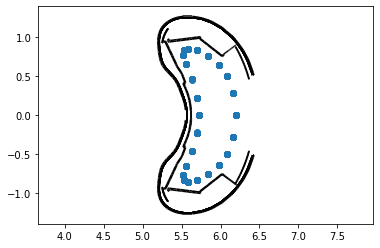

In [8]:
rSurf = np.sqrt(xSurf**2 + ySurf**2)
plt.scatter(rSurf[0], zSurf[0])
geometry.plotCut(startPlanes[0], color='k')
plt.axis("equal")
xSurf.shape

Since the surface looks OK we can now start to do our tracing on the nTurns * nPlanes = 2000 points we obtained. Since we want to do diffusive tracing, we enable the parallel diffusion model.

In [9]:
traceResult = fsc.flt.trace(
    [xSurf, ySurf, zSurf], field, geometry,
    distanceLimit = 0, # Disable distance limit
    collisionLimit = 1, # Terminate field line on first collision
    meanFreePath = 1, meanFreePathGrowth = 0.1,
    parallelDiffusionCoefficient = 1,
    # parallelConvectionVelocity = 1,
    isotropicDiffusionCoefficient = 1e-7
)

The result of flt.trace is a superset of the Poincare and connection-length functions (in fact these functions just call trace and return part of the result). Of interest for us is the dict entry 'endPoints', which contains 4 pieces of information about the end points: Their x, y, and z coordinates as well as the length of the field line (which we don't care about here). Since we know the final distribution to be Stellarator-symmetric, we symmetrize the heat loads between our divertors to get better statistics.

In [13]:
print(traceResult.keys())
print(traceResult['endPoints'].shape)
xyz = traceResult['endPoints'][0:3]
xyz = fsc.flt.symmetrize(xyz, nSym = 5, stellaratorSymmetric = True)
print(xyz.shape)

dict_keys(['endPoints', 'poincareHits', 'stopReasons', 'endTags', 'responseSize'])
(4, 10, 200)
(3, 10, 10, 200)


To obtain the heat loads from the point cloud, we use the 'hfcam' module. To do that, we need to follow the following steps:
- Define a projection view
- Build a camera that contains a rasterized geometry mesh and infos about the rasterization.
- Render the points into the camera image.

In [14]:
camGeo = w7x.divertor('OP21')# + w7x.baffles('OP21')
camProj = fsc.hfcam.toroidalProjection(
    w = 2500, h = 1200,
    #w = 625, h = 300,
    phi = np.radians(7), rTarget = 5.8, zTarget = -0.5,
    verticalInclination = np.radians(30), horizontalInclination = 0,
    distance = 0.5, viewportHeight = 2.5,
    fieldOfView = np.radians(0)
)
cam = fsc.hfcam.make(camProj, camGeo, depthTolerance = 0)

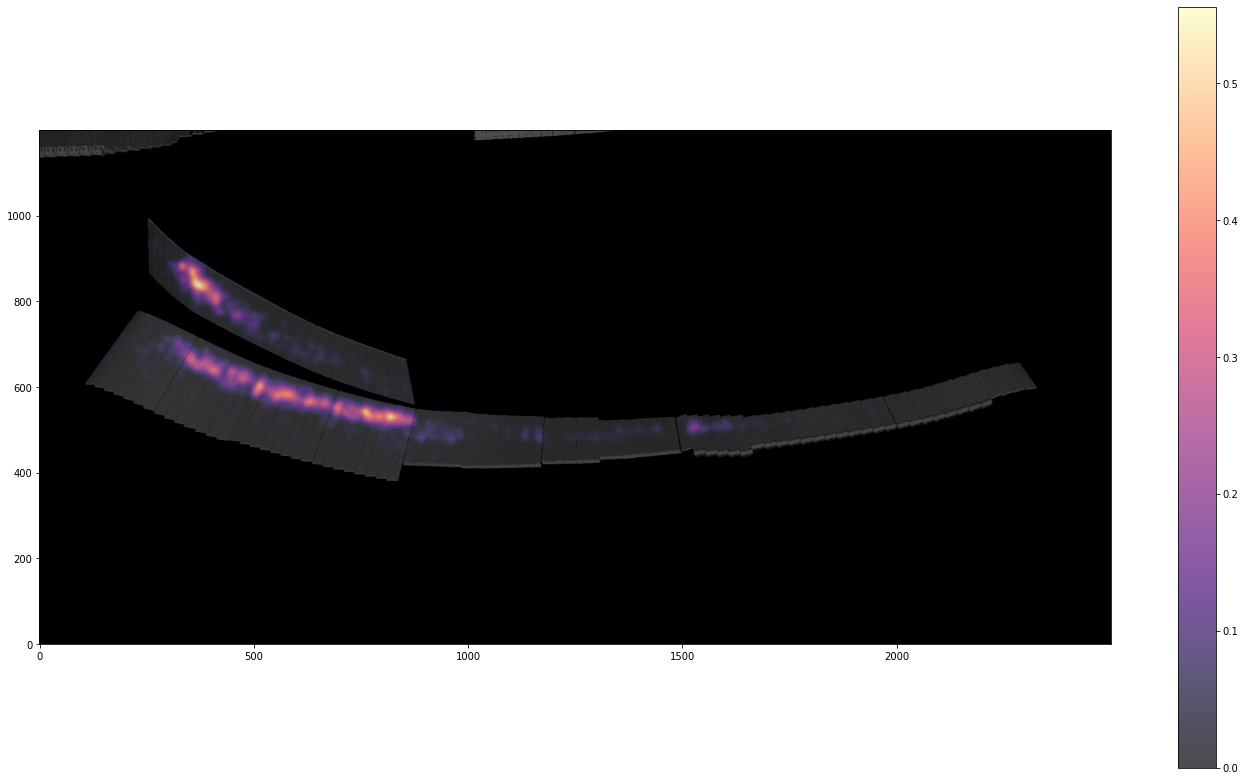

In [20]:
camData = cam.getData()
detBuf = np.asarray(camData.determinantBuffer)
cam.clear()
cam.addPoints(xyz, r = 0.02)
result = cam.get()

plt.figure(figsize = (24, 14))
plt.imshow(detBuf.T, origin ='lower', cmap = 'gray')
plt.imshow(np.asarray(result.image).T / xyz.size * 3, origin = 'lower', cmap = 'magma', alpha=0.7)
plt.colorbar()